# Laboratorio 4.1

* Curso: Simulación Estocástica: Teoría y Laboratorio (MA4402)
* Profesor: Joaquin Fontbona T.
* Profesores auxiliares: Pablo Araya Z., Bruno Hernández P.
* Estudiantes: Camilo Carvajal Reyes, Manuel Torres V., Felipe Urrutia.

# Preliminares

In [ ]:
from itertools import  cycle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from matplotlib import animation
from IPython.display import HTML

plt.style.use('seaborn-darkgrid')
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})

# Problema 2: 


## Parte 1: Datos

Cargar conjunto de datos:

In [ ]:
from sklearn.datasets import load_boston

data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["PRICE"] = data.target

Informacion del conjunto de datos:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


**Comentarios:** Hay $14$ columnas en total, las primeras $13$ son columnas de atributos y la ultima para la variable a predecir $\texttt{PRICE}$

Normalizar datos:

In [ ]:
data_cols = list(df.columns[:-1])
df[data_cols] = (df[data_cols] - df[data_cols].mean()) / df[data_cols].std()
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,506.000000
mean,8.326673e-17,3.466704e-16,-3.016965e-15,3.999875e-16,3.563575e-15,-1.149882e-14,-1.158274e-15,7.308603e-16,-1.068535e-15,6.534079e-16,-1.084420e-14,8.117354e-15,-6.494585e-16,22.532806
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.197104
min,-4.193669e-01,-4.872402e-01,-1.556302e+00,-2.723291e-01,-1.464433e+00,-3.876413e+00,-2.333128e+00,-1.265817e+00,-9.818712e-01,-1.312691e+00,-2.704703e+00,-3.903331e+00,-1.529613e+00,5.000000
25%,-4.105633e-01,-4.872402e-01,-8.668328e-01,-2.723291e-01,-9.121262e-01,-5.680681e-01,-8.366200e-01,-8.048913e-01,-6.373311e-01,-7.668172e-01,-4.875567e-01,2.048688e-01,-7.986296e-01,17.025000
50%,-3.902803e-01,-4.872402e-01,-2.108898e-01,-2.723291e-01,-1.440749e-01,-1.083583e-01,3.170678e-01,-2.790473e-01,-5.224844e-01,-4.642132e-01,2.745872e-01,3.808097e-01,-1.810744e-01,21.200000
75%,7.389247e-03,4.872402e-02,1.014995e+00,-2.723291e-01,5.980871e-01,4.822906e-01,9.059016e-01,6.617161e-01,1.659603e+00,1.529413e+00,8.057784e-01,4.332223e-01,6.024226e-01,25.000000
max,9.924110e+00,3.800473e+00,2.420170e+00,3.664771e+00,2.729645e+00,3.551530e+00,1.116390e+00,3.956602e+00,1.659603e+00,1.796416e+00,1.637208e+00,4.406159e-01,3.545262e+00,50.000000


**Comentarios:** En general, normalizar los datos produce un mejor performance de un modelo de regresion

Añadir columna para intercepto:

In [ ]:
df["INTERCEPTO"] = 1
data_cols.append("INTERCEPTO")

## Parte 2: Pre-procesamiento

In [ ]:
from sklearn.model_selection import train_test_split

X, y = df[data_cols], df["PRICE"]
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.30, random_state=777, shuffle=True)

**Comentarios:** Esto es necesario para validar nuestro modelo sobre un conjunto que no haya sido utilizado durante el entrenamiento. Ademas, se recomienda desordenar los datos para evitar algun orden que no queramos en nuestros datos.

## Parte 3: Learning rates constantes y varables

Consideremos el siguiente problema de minimizacion:
$$ \min_w \mathbb{E}(f(w, d))$$
donde $w = (\theta, b)$ y $f(w, (x, y)) := \frac{1}{2}(y-w^T (x, 1))^2$.

El metodo de SGD viene dado por
$$w_{t+1} = w_t - \gamma_t \partial_w f(w_t, d_{t+1})$$
con $d_{t+1} = (x_{t+1}, y_{t+1})$ y $\gamma_t$ una sucesion de *learning rates*.

Falta computar $\partial_w f(w, (x, y))$. En efecto, 

$$\partial_w f(w, (x, y)) = \partial_w \frac{1}{2}(y-w^T (x, 1))^2 = (y-w^T (x, 1)) \partial_w (y-w^T (x, 1)) = -(y-w^T (x, 1))(x, 1).$$

Recordar que nuestros datos consideran una columna igual a 1 para el intercepto, entonces $x \mapsto (x, 1)$.

### Clase $\texttt{SGD}$

El algoritmo de SGD es implementado sobre una clase con los siguientes metodos:

*   $\texttt{__init__}$: Iniciar la clase con datos de entrenamiento $\texttt{X}$ para atributos, $\texttt{y}$ variable a predecir y $\texttt{w0}$ un hiperplano inicial
*   $\texttt{fit}$: Permite correr el algoritmo de SGD y pide una funcion $\texttt{gamma}$ (o ''learning rate'')

el resto de metodos son utiles internamente para el metodo $\texttt{SGD}$, o bien, metodos que permiten graficar.




In [ ]:
def eval_reg(w, X):
  return X @ w

class SGD():

  def __init__(self, X, y, w0):
    self.X = X
    self.y = y
    self.n = X.shape[0]
    self.path = []
    self.w0 = w0
  
  def fit(self, gamma):
    """
    Implementacion de algortimo SDG

    gamma: learning rate
    w0: hiperplano inicial
    """

    self.path = []
    wt_1 = self.w0
    val_E_f_t_1 = self.E_f(wt_1, self.X, self.y)
    self.path.append((wt_1, val_E_f_t_1))
    self.val = val_E_f_t_1

    for t in range(self.n):
      gammat = gamma(t)
      xt, yt = self.X[t], self.y[t]
      df_dw_t = self.df_dw(wt_1, np.array([xt]), np.array([yt]))
      wt_1 = wt_1 - gammat * df_dw_t

      val_E_f_t = self.E_f(wt_1, self.X, self.y)
      self.path.append((wt_1, val_E_f_t))
      if self.val > val_E_f_t:
        self.val = val_E_f_t
        self.w = wt_1

  def E_f(self, w, X, y):
    """
    Esperanza de la funcion f para un conjunto de datos (X, y) e hiperplano w
    """
    y_pred = eval_reg(w, X)
    return self.error(y, y_pred)

  def df_dw(self, w, X, y):
    """
    Derivada parcial de f c/r a w
    """
    y_pred = eval_reg(w, X)
    m = y_pred.shape[0]
    return -(1/m)*np.sum( np.diag(y - y_pred) @ X, axis=0)
  
  def predict(self, X):
    """
    Funcion que permite predecir usando el hiperplano con SGD e input X
    """
    return eval_reg(self.w, X)
  
  def score(self, X, y):
    """
    Valor de la funcion objetivo para datos (X, y)
    """
    return self.E_f(self.w, X, y)

  def error(self, y, y_pred):
    """
    EMC para datos de referencia 'y' e variable predicha 'y_pred' 
    """
    return np.mean(1/2 * ((y-y_pred)**2)) 

  def performance(self, X, y):
    """
    Valor de EMC para conjunto de entranamiento y testeo
    """
    EMC_train = self.val
    y_pred = eval_reg(self.w, X)
    EMC_test = self.error(y, y_pred)
    return {"train": EMC_train, "test": EMC_test}

  def plot_animation(self):
    fig = plt.figure(figsize=(3, 3))
    fig.tight_layout()

    ax = fig.add_subplot(111)

    info = self.path[0]
    y_pred = eval_reg(info[0], X_train)
    ax.scatter(self.y, y_pred, label=info[1], color="tab:blue")
    plt.close()

    def aframe(t):
      t+=1
      ax.clear()
      info = self.path[t]
      y_pred = eval_reg(info[0], self.X)
      
      y_train_visited, y_train_others = self.y[:t], self.y[t:]
      y_pred_visited, y_pred_others = y_pred[:t], y_pred[t:]

      ax.scatter(y_train_visited, y_pred_visited, label=info[1], color="tab:green")
      ax.scatter(y_train_others, y_pred_others, label=info[1], color="tab:blue")
      ax.scatter([y_train_visited[-1]], [y_pred_visited[-1]], label=info[1], color="tab:red")

      return t,
      
    ani = animation.FuncAnimation(fig, aframe, range(0, self.n, 5), blit=False,
                                      repeat=False)
    return HTML(ani.to_html5_video())
  
  def plot_E_f(self, dic):
    fig, ax = plt.subplots(1, 1, figsize=(5*2, 5)) 
    fig.tight_layout()
    y_data = [p[1] for p in self.path]
    y_min = min(y_data)
    ax.axhline(y=y_min, color='r', linestyle='-', alpha=0.5, label=f"min E(f)={y_min: .4f}")
    ax.plot(y_data)
    ax.legend()
    ax.set_title(r"Valor de $E(f)$ por iteración con $\gamma_t$ "+dic["caso"]+" de parámetro "+str(dic["tipo"]))

    ax.set_ylabel(r"$E(f)$: valor función objetivo")
    ax.set_xlabel(r"$t$: iteración")

  def plot_status(self, X, y):
    fig, ax = plt.subplots(1, 3, figsize=(5*3, 5)) 
    ex = [min(self.y), max(self.y)]
    for i, t in enumerate([0, -1]):
      info = [self.path[t], [self.w, self.val]][i]
      y_pred = eval_reg(info[0], self.X)
      ax[i].scatter(self.y, y_pred, label=f"{info[1]:.3f}")
      if i:
        ax[i].plot(ex, ex, color="tab:red", alpha=0.6)
      ax[i].set_xlabel("y train")
      if not i:
        ax[i].set_ylabel("y pred")
        ax[i].set_title(f"Train: Inicial ECM={info[1]:.3f}")
      else:
        ax[i].set_title(f"Train: Mejor ECM={info[1]:.3f}")
    y_pred = eval_reg(self.w, X)
    ax[2].scatter(y, y_pred)
    ex = [min(y), max(y)]
    ax[2].plot(ex, ex, color="tab:red", alpha=0.6)
    ax[2].set_xlabel("y test")
    ax[2].set_title(f"Test: ECM={self.error(y, y_pred):.3f}")

Inicializar clase SGD

In [ ]:
# Hiperplano inicial
cand_w = np.ones(X_train.shape[1])
# clase SGD con datos de entrenamiento e hiperplano inicial
sgd = SGD(X_train, y_train, w0=cand_w)
# tabla para evaluacion de learning rates
tabla_learning_rates = []

### Test de learning rates constantes

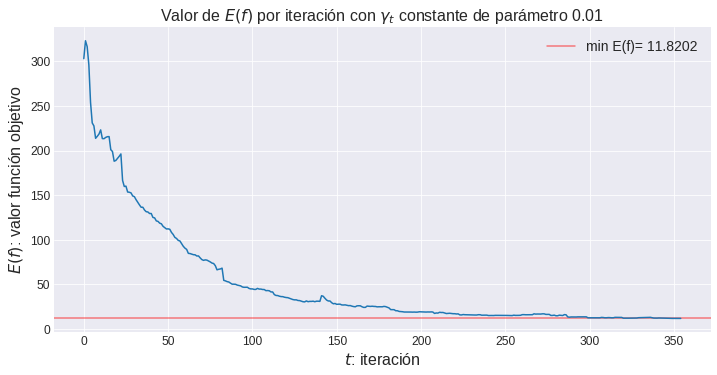

In [ ]:
sgd.fit(gamma=lambda _: 0.01)
sgd.plot_E_f({"caso": "constante", "tipo": 0.01})

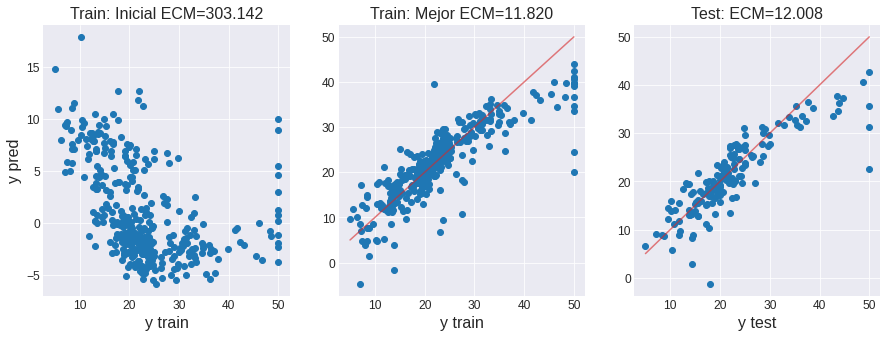

In [ ]:
sgd.plot_status(X_test, y_test)

In [ ]:
sgd.plot_animation() 

**Comentarios**: El video posee los siguientes elementos: avanza segun la iteracion, los puntos azules son los datos que no han sido utilizados en las perturbaciones del parametro actual, a diferencia de aquellos verdes y el unico punto rojo, donde los verdes son los datos que ya fueron visitados para el calculo del gradiente y el punto rojo es el dato actual que produce las innovaciones en el parametro para la siguiente iteracion. El eje $\hat{x}$, al igual que los graficos anteriores, indica la variable conocida a predecir mientras que el eje $\hat{y
}$ son las predicciones. Finalmente, se observa que mientras mas datos se observan (avanzan las iteraciones) se obtiene mejores predicciones al ver que las predicciones son mas similares a los datos de referencia viendose como la identidad.

In [ ]:
#@title Se testea con constantes en $\{0.01, 0.05, 0.001\}$

for c in [0.01, 0.05, 0.001]:
  sgd.fit(gamma=lambda _: c)
  pc = sgd.performance(X_test, y_test)
  tabla_learning_rates.append({
        "tipo": "constante", 
        "learning rate": c,
        "EMC Train": pc["train"],
        "EMC Test": pc["test"]
    })

### Test de learning rate variables

Se proponen los siguientes learning rates variables:    


*   $\texttt{1/x}$: Para una constante $a>0$, $$\gamma(x) = \frac{a}{x+1}$$
*   $\texttt{exp}$: Para constantes $a, b>0$, $$\gamma(x) = a \exp\{-b x\}$$
*   $\texttt{sqrt(1/x)}$: Para constantes $a, b>0$, $$\gamma(x) = a \sqrt{\frac{b}{x+1}}$$
*   $\texttt{rational}$: Para constante $a>0$, $$a \frac{x+2}{x+1}$$



In [ ]:
learning_rates = {
    "1/x": lambda x, a: a/(x+1),
    "exp": lambda x, a, b: a*np.exp(-b*x),
    "sqrt(1/x)": lambda x, a, b: a*np.sqrt(b/(x+1)),
    "rational": lambda x, a: a * (x+2) / (x+1)
}

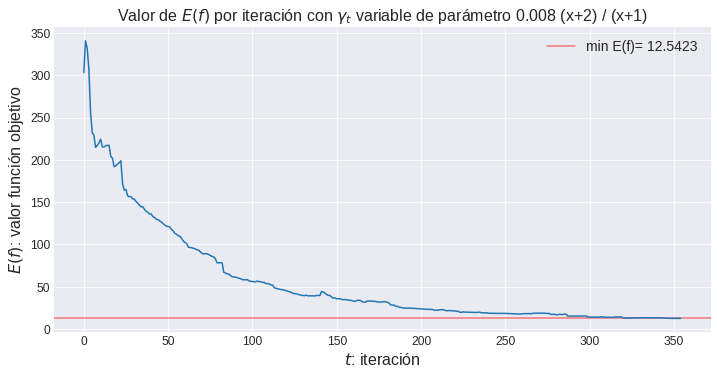

In [ ]:
#@title $\texttt{Rational}$ de constante $0.008$ {display-mode: "form"}
sgd.fit(gamma=lambda x: learning_rates["rational"](x, 0.008))
sgd.plot_E_f({"caso": "variable", "tipo": "0.008 (x+2) / (x+1)"})
pc = sgd.performance(X_test, y_test)
tabla_learning_rates.append({
      "tipo": "variable", 
      "learning rate": "rational(a=0.008)",
      "EMC Train": pc["train"],
      "EMC Test": pc["test"]
  })

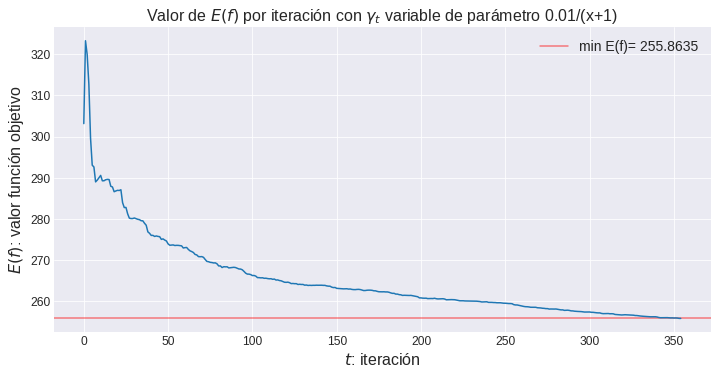

In [ ]:
#@title $\texttt{1/x}$ de constante $0.01$ {display-mode: "form"}
sgd.fit(gamma=lambda x: learning_rates["1/x"](x, 0.01))
sgd.plot_E_f({"caso": "variable", "tipo": "0.01/(x+1)"})
pc = sgd.performance(X_test, y_test)
tabla_learning_rates.append({
      "tipo": "variable", 
      "learning rate": "1/x(a=0.01)",
      "EMC Train": pc["train"],
      "EMC Test": pc["test"]
  })

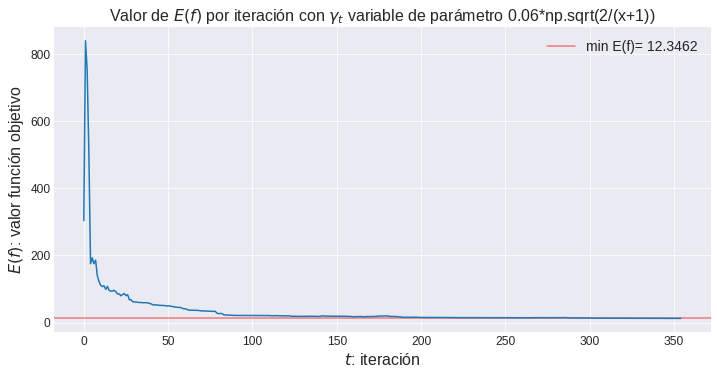

In [ ]:
#@title $\texttt{sqrt(1/x)}$ de constantes $(0.06, 2)$ {display-mode: "form"}
sgd.fit(gamma=lambda x: learning_rates["sqrt(1/x)"](x, 0.06, 2))
sgd.plot_E_f({"caso": "variable", "tipo": "0.06*np.sqrt(2/(x+1))"})
pc = sgd.performance(X_test, y_test)
tabla_learning_rates.append({
      "tipo": "variable", 
      "learning rate": "sqrt(1/x)(a=0.06, b=2)",
      "EMC Train": pc["train"],
      "EMC Test": pc["test"]
  })

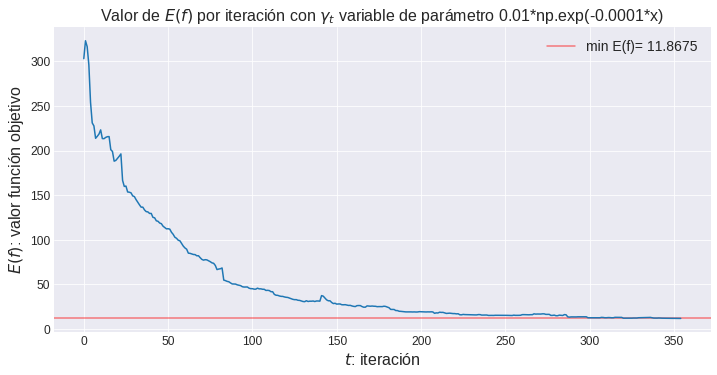

In [ ]:
#@title $\texttt{exp}$ de constantes $(0.01, 0.0001)$ {display-mode: "form"}
sgd.fit(gamma=lambda x: learning_rates["exp"](x, 0.01, 0.0001))
sgd.plot_E_f({"caso": "variable", "tipo": "0.01*np.exp(-0.0001*x)"})
pc = sgd.performance(X_test, y_test)
tabla_learning_rates.append({
      "tipo": "variable", 
      "learning rate": "exp(a=0.01, b=0.0001)",
      "EMC Train": pc["train"],
      "EMC Test": pc["test"]
  })

### Tabla de resultados

In [ ]:
pd.DataFrame(tabla_learning_rates)

,tipo,learning rate,EMC Train,EMC Test
0,constante,0.01,11.820177,12.007712
1,constante,0.05,11.312510,14.786439
2,constante,0.001,132.237099,140.346388
3,variable,rational(a=0.008),12.542253,12.919750
4,variable,1/x(a=0.01),255.863517,258.030108
5,variable,"sqrt(1/x)(a=0.06, b=2)",12.346206,14.089380
6,variable,"exp(a=0.01, b=0.0001)",11.867548,12.001071


**Comentarios:** Primero, para los learning rates constantes se observa que valores pequeños producen que el algoritmo avance lento hacia un buen minimo, con los que se obtienen peores resultados (p.ej. con 0.001) tanto en el conjunto de test como de entrenamiento. Se observa que para un parametro $0.05$ se produce un overfittig mas marcado que con un parametro $0.01$ viendo que el EMC en el conjunto de entrenamiento es mucho menor que en el conjunto de test. Ahora bien, para los learning rates variables se observa que el $\texttt{1/x}$ es el que obtiene peores resultado, esto se puede interpretar como sigue: mientras pasa el numero de iteraciones el paso es cada vez menor provocando que el algoritmo deje de avanzar antes de llegar a un buen minimo. El $\texttt{exp}$ obtiene un buen resultado, tanto como un learning rate constante, esto dado que la eleccion del segundo de sus parametros produce que este se comporte como un learing rate constante de leve variacion. Con el resto de los learning rates variables se obtienen valores similares.

## Parte 4: Mini-batch

In [ ]:
def fit_minibatch(self, gamma, w0, m=1):
  """
  Implementacion de algoritmo SGD con mini-batch.
  m: tamaño del batch
  """
  self.path = []
  
  def get_batch():
    b = []
    for _, *indexs in zip(range(self.n), *[cycle(range(self.n))] * m):
      mask = np.zeros(self.n, bool)
      mask[indexs] = True
      b.append([self.X[mask], self.y[mask]])
    return b

  wt_1 = w0
  batch = get_batch()

  val_E_f_t_1 = self.E_f(wt_1, self.X, self.y)
  self.path.append((wt_1, val_E_f_t_1))
  self.val = val_E_f_t_1

  for t in range(self.n):
    gammat = gamma(t)
    batcht = batch[t]
    df_dw_t = self.df_dw(wt_1, batcht[0], batcht[1])
    wt_1 = wt_1 - gammat * df_dw_t
    
    val_E_f_t = self.E_f(wt_1, self.X, self.y)
    self.path.append((wt_1, val_E_f_t))
    if self.val > val_E_f_t:
      self.val = val_E_f_t
      self.w = wt_1

setattr(SGD, "fit_minibatch", fit_minibatch)

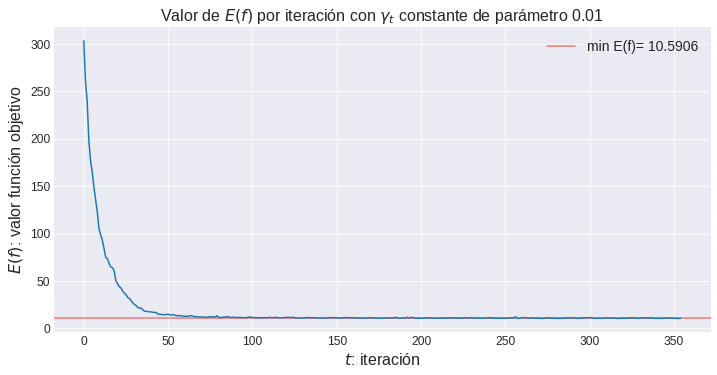

In [ ]:
sgd.fit_minibatch(gamma=lambda _: 0.05, w0=cand_w, m=10)
sgd.plot_E_f({"caso": "constante", "tipo": 0.01})

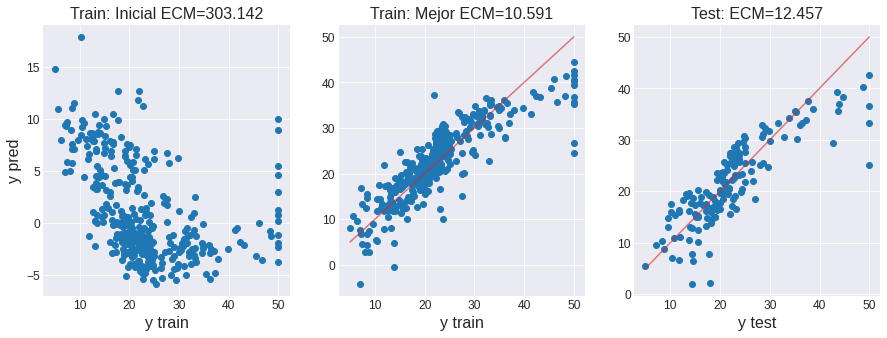

In [ ]:
sgd.plot_status(X_test, y_test)

In [ ]:
#@title Tabla de resultados {display-mode: "form"}
#@markdown Se testea con minibatch de tamaños $\{1, 10, 50\}$ y learning rates constante en $\{0.01, 0.05\}$

tabla_minibatch = []
for c in [0.01, 0.05]:
  for m0 in [1, 5, 10, 50]:
    sgd.fit_minibatch(gamma=lambda _: c, w0=cand_w, m=m0)
    pc = sgd.performance(X_test, y_test)
    tabla_minibatch.append({
          "tipo": "constante", 
          "learning rate": c,
          "tamaño batch": m0,
          "EMC Train": pc["train"],
          "EMC Test": pc["test"]
      })
pd.DataFrame(tabla_minibatch)

,tipo,learning rate,tamaño batch,EMC Train,EMC Test
0,constante,0.01,1,11.820177,12.007712
1,constante,0.01,5,11.908316,12.276214
2,constante,0.01,10,11.901925,12.275858
3,constante,0.01,50,11.902251,12.276168
4,constante,0.05,1,11.312510,14.786439
5,constante,0.05,5,10.660695,12.492963
6,constante,0.05,10,10.590566,12.457013
7,constante,0.05,50,10.565272,12.407117


**Comentarios:** Se eligen learning rates constantes de parametros $0.01$ y $0.05$ por su desempeño en la seccion $3$. Podemos notar que cuanto mayor es el tamaño del minibatch se obtiene mejores resultados en el conjunto de entrenamiento (overfitting) que sobre el conjunto de testeo, en comparacion al algoritmo usual de SGD con $m=1$. Este efecto es mas notorio con learning rate igual a $0.05$, que se puede interpretar como sigue: saltos grandes (learning rate constante grande) y mejor aproximacion de la esperanza de la funcion objetivo (minibatch grandes), permiten saltos seguros en menos iteraciones a un buen minimo pero solo para el conjunto de entrenamiento, y no necesariamente un buen minimio sobre el conjunto de test, produciendo un overfitting.

## Parte 5: Momentum y Adagrad

### Momentum

In [ ]:
def fit_momentum(self, beta, eta, m0=0):
  self.path = []
  wt_1 = self.w0
  mt_1 = m0

  val_E_f_t_1 = self.E_f(wt_1, self.X, self.y)
  self.path.append((wt_1, val_E_f_t_1))
  self.val = val_E_f_t_1

  for t in range(self.n):
    xt, yt = self.X[t], self.y[t]
    df_dw_t = self.df_dw(wt_1, np.array([xt]), np.array([yt]))
    mt = beta * mt_1 + (1-beta) * df_dw_t
    
    wt_1 = wt_1 - eta * mt
    mt_1 = mt

    val_E_f_t = self.E_f(wt_1, self.X, self.y)
    self.path.append((wt_1, val_E_f_t))
    if self.val > val_E_f_t:
      self.val = val_E_f_t
      self.w = wt_1

setattr(SGD, "fit_momentum", fit_momentum)

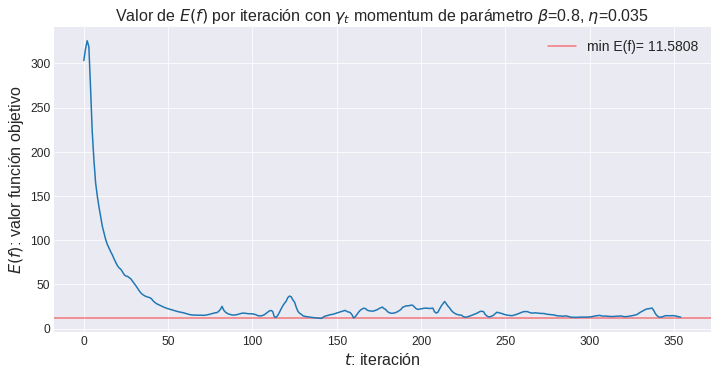

In [ ]:
sgd.fit_momentum(beta=0.8, eta=0.035, m0=0)
sgd.plot_E_f({"caso": "momentum", "tipo": r"$\beta$=0.8, $\eta$=0.035"})

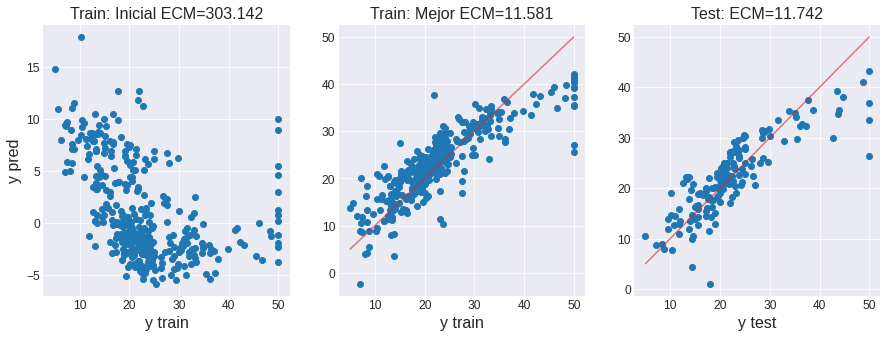

In [ ]:
sgd.plot_status(X_test, y_test)

#### Test parametros

In [ ]:
#@title Data {display-mode: "form"}
#@markdown Se testea con parametros $\beta$ en rango $(0,1)$ y $\eta$ en rango $(0.001, 0.1)$ con una grilla de tamaño $30\times 30$

#Params
b0= 0  
b1 = 1 
e0 = 0.001 
e1 = 0.1 
size_linspace = 30 
#Calcular imagen
betas = np.linspace(b0, b1, num=size_linspace)
etas = np.linspace(e0, e1, num=size_linspace)
sgd_momentum = SGD(X_train, y_train, w0=cand_w)
grid = []
soft_std = []
for b in betas:
  row = []
  row_s = []
  for e in etas:
    sgd_momentum.fit_momentum(beta=b, eta=e, m0=0)
    row.append(sgd_momentum.val)
    i_set = [abs(sgd_momentum.path[i+1][1]-sgd_momentum.val)/abs(sgd_momentum.path[i][1]-sgd_momentum.val) for i in range(len(sgd_momentum.path)-1) if not math.isclose(sgd_momentum.path[i][1], sgd_momentum.val, rel_tol=1e-02)]
    row_s.append(np.std(i_set))
  grid.append(row)
  soft_std.append(row_s)
soft_std = np.array(soft_std)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
#@title Grafico min E(f) {display-mode: "form"}
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.imshow(np.flip(grid, 0), cmap="Spectral_r", extent=[e0, e1, b0, b1], vmax=35, vmin=10)
cbar = ax.figure.colorbar(im)
cbar.outline.set_visible(False)
labels = [str(_) for _ in range(10, 35, 5)] + [">35"]
cbar.ax.set_yticklabels(labels)
ax.set_xlabel(r"$\eta$: eta")
ax.set_ylabel(r"$\beta$: beta")
ax.grid(False)
ax.set_aspect((e1-e0)/(b1-b0))
ax.set_title(r"min $E(f)$")
print()

NameError: ignored

**Comentarios:** Se observa que para $\eta$ en el rango $(0.01, 0.05)$ se obtienen mejores valores para el minimo de la funcion objetivo con casi cualquier $\beta$ en $(0,1)$ (excepto $\beta = 1$). Si $0.06 < \eta < 0.1$y  $\beta$ en la region $(0.4, 0.95)$, se  obtienen pesimos resultados. 

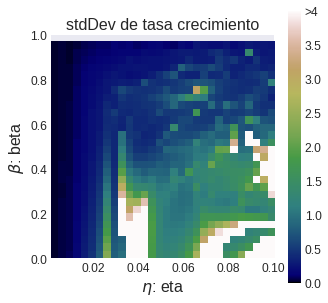

In [ ]:
#@title Grafico stdDev de tasa de crecimiento {display-mode: "form"}
#@markdown La i-esima tasa de crecimiento esta dada por $$\frac{|\mathbb{E}(f)_{i+1}-\min\mathbb{E}(f)|}{|\mathbb{E}(f)_{i}-\min\mathbb{E}(f)|}$$

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.imshow(np.flip(soft_std, 0), cmap="gist_earth", extent=[e0, e1, b0, b1], vmax=4, vmin=0)
cbar = ax.figure.colorbar(im)
cbar.outline.set_visible(False)
labels = [str(_) for _ in np.linspace(0, 4, 9)[:-1]] + [">4"]
cbar.ax.set_yticklabels(labels)
ax.set_xlabel(r"$\eta$: eta")
ax.set_ylabel(r"$\beta$: beta")
ax.grid(False)
ax.set_aspect((e1-e0)/(b1-b0))
ax.set_title(r"stdDev de tasa crecimiento")
print()

**Comentarios:** Se observa que la tasa de crecimiento varia menos cuando $\eta$ viven entre $(0.001, 0.02)$ para casi cualquier $\beta$ en $(0,1)$ (zona azul) y en los graficos esto se ve que la curva de la funcion objetivo sobre las iteraciones es mas suave. Esto significa que la curva de la funcion objetivo decrece al minimo con menos oscilaciones en dicho rectangulo que para $\eta>0.02$ (zona verde con manchas blancas). En particular, para $\beta=1$ la funcion objetivo se mantiene constante dado que no se realizan perturbacion sobre el parametro inicial. Si $0.02 < \eta < 0.1$ y $\beta$ en la region $(0.5, 0.95)$, la variacion de oscilaciones es baja excepto en algunos punto (verdes).

### Adagrad

In [ ]:
def fit_adagrad(self, c, eta, v0=0):
  self.path = []
  wt_1 = self.w0
  vt = v0

  val_E_f_t_1 = self.E_f(wt_1, self.X, self.y)
  self.path.append((wt_1, val_E_f_t_1))
  self.val = val_E_f_t_1

  for t in range(self.n):
    xt, yt = self.X[t], self.y[t]
    df_dw_t = self.df_dw(wt_1, np.array([xt]), np.array([yt]))
    
    vt += np.linalg.norm(df_dw_t, ord=2)**2
    eta_t = eta / np.sqrt(vt+c)
    wt_1 = wt_1 - eta_t * df_dw_t

    val_E_f_t = self.E_f(wt_1, self.X, self.y)
    self.path.append((wt_1, val_E_f_t))
    if self.val > val_E_f_t:
      self.val = val_E_f_t
      self.w = wt_1
    
  self.w = wt_1

setattr(SGD, "fit_adagrad", fit_adagrad)

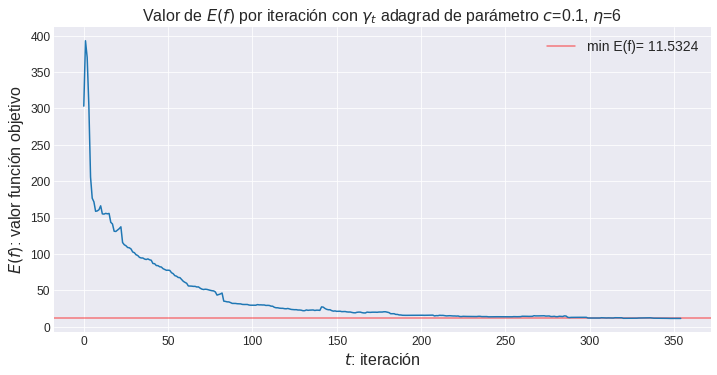

In [ ]:
sgd.fit_adagrad(c=0.1, eta=6, v0=0)
sgd.plot_E_f({"caso": "adagrad", "tipo": r"$c$=0.1, $\eta$=6"})

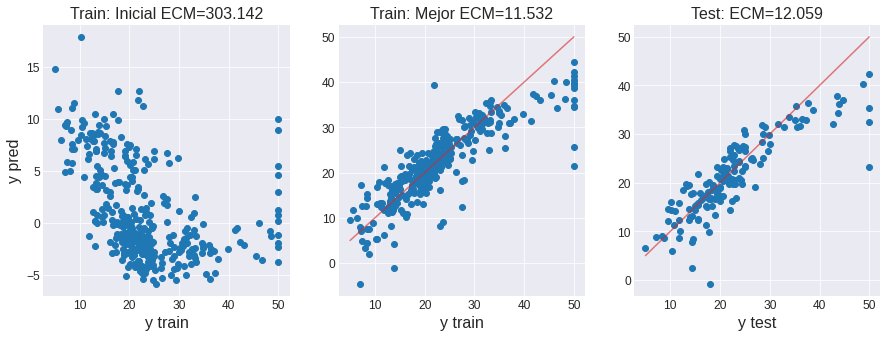

In [ ]:
sgd.plot_status(X_test, y_test)

#### Test parametros

In [ ]:
#@title Data {display-mode: "form"}
#@markdown Se testea con parametros $c$ en rango $(0,500000)$ y $\eta$ en rango $(0.8, 7)$ con una grilla de tamaño $10\times 10$

#Params
c0= 0  
c1 = 500000
e0 = 0.8
e1 = 7  
size_linspace = 10 
#Calcular imagen
ces = np.linspace(c0, c1, num=size_linspace)
etas = np.linspace(e0, e1, num=size_linspace)
sgd_adagrad = SGD(X_train, y_train, w0=cand_w)
grid = []
soft_std = []
for c in ces:
  row = []
  row_s = []
  for e in etas:
    sgd_adagrad.fit_adagrad(c=c, eta=e, v0=0)
    row.append(sgd_adagrad.val)
    i_set = [abs(sgd_adagrad.path[i+1][1]-sgd_adagrad.val)/abs(sgd_adagrad.path[i][1]-sgd_adagrad.val) for i in range(len(sgd_adagrad.path)-1) if not math.isclose(sgd_adagrad.path[i][1], sgd_adagrad.val, rel_tol=1e-02)]
    row_s.append(np.std(i_set))
  grid.append(row)
  soft_std.append(row_s)
soft_std = np.array(soft_std)

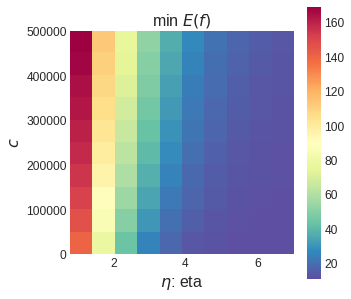

In [ ]:
#@title Grafico min E(f) {display-mode: "form"}
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.imshow(np.flip(grid, 0), cmap="Spectral_r", extent=[e0, e1, c0, c1])
cbar = ax.figure.colorbar(im)
cbar.outline.set_visible(False)
ax.set_xlabel(r"$\eta$: eta")
ax.set_ylabel(r"$c$")
ax.grid(False)
ax.set_aspect((e1-e0)/(c1-c0))
ax.set_title(r"min $E(f)$")
print()

**Comentarios**: Se observa que la constante $c$ del learning rate propuesto por Adagrad no produce cambios significativos sobre los minimos alcanzados por el algoritmo, se testea hasta un valor exagerado iguala $c=500000$ donde las diferencias son sutiles. Notar que el parametro que juega un rol principal es el $\eta$ donde valores mayores que $4$ permiten obtener buenos minimos.

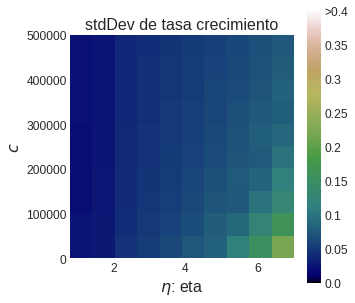

In [ ]:
#@title Grafico stdDev de tasa de crecimiento {display-mode: "form"}
#@markdown La i-esima tasa de crecimiento esta dada por $$\frac{|\mathbb{E}(f)_{i+1}-\min\mathbb{E}(f)|}{|\mathbb{E}(f)_{i}-\min\mathbb{E}(f)|}$$

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.imshow(np.flip(soft_std, 0), cmap="gist_earth", extent=[e0, e1, c0, c1], vmax=0.4, vmin=0)
cbar = ax.figure.colorbar(im)
cbar.outline.set_visible(False)
labels = [str(np.round(_, decimals=2)) for _ in np.linspace(0, 0.4, 9)[:-1]] + [">0.4"]
cbar.ax.set_yticklabels(labels)
ax.set_xlabel(r"$\eta$: eta")
ax.set_ylabel(r"$c$")
ax.grid(False)
ax.set_aspect((e1-e0)/(c1-c0))
ax.set_title(r"stdDev de tasa crecimiento")
print()

**Comentarios:** Se observa que para valores de $c>0$ menores que $100000$ generan una region verde con $4\leq\eta\leq6$ donde el algoritmo oscila mas y/o decae mas rapido a un minimo.